# Algorytmy ewolucyjne i genetyczne

Implementacja algorytmu ewolucyjnego z selekcją ruletkową, krzyżowaniem jednopunktowym, mutacją gaussowską oraz sukcesją generacyjną.
Wykorzystanie implementacji do znalezienia rozwiązanie dające minimalny koszt dla problemu optymalizacyjnego.
Optymalizacja zestawu hiperparametrów dla zadanego problemu i zbadanie jego wpływu na wynik.

## Opis problemu – lokalizacja fabryki

Znaleźć optymalną lokalizację dla fabryki, jeżeli korzysta ona z 4 zasobów. Zakładamy przy tym, że:


* lokalizacja fabryki określona jest przez jej współrzędne $(x1, x2)∈R^2$,
* dzienne zapotrzebowanie fabryki to:
    * 20 jednostek zasobu $z_1$ transportowanego ze współrzędnych (1, 1),
    * 10 jednostek zasobu $z_2$ transportowanego ze współrzędnych (-0.5, 1),
    * 5 jednostek zasobu $z_3$ transportowanego ze współrzędnych (-1, -0.5),
    * 10 jednostek zasobu $z_4$ transportowanego ze współrzędnych (1, -1),
* koszt transportu jednostki każdego z zasobów wyliczany to $1−e^{−d_M}$, gdzied $M$ to odległość Manhattan od lokalizacji fabryki,
* celem optymalizacji jest znalezienie lokalizacji fabryki, która minimalizuje sumaryczny dzienny koszt dostarczania zasobów do fabryki.

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from multiprocessing import Pool
import os, time

## Funkcja score

In [2]:
def score(x, y):
    '''
    Funkcja zwracająca koszt transportu jednostki każdego z zasobów, uwzględniajaca 
    odległość Manhattan od lokalizacji fabryki (x, y).
    
    '''
    res = np.zeros_like(x)
    for pos, count in [
        ((1, 1), 20),
        ((-0.5, 1), 10),
        ((-1, -0.5), 5),
        ((1, -1), 10),
    ]:
        d = abs(x - pos[0]) + abs(y - pos[1]) 
        res += count * (1 - np.exp(-d))
    return res

## Krzyżowanie jednopunktowe

In [3]:
def cross_one(population, p):
    '''
    funkcja krzyżowania jednopunktowego przyjmująca dwa argumenty ->
    populację oraz prawdopodobieństwo krzyżowania zwracająca skrzyzowana populacje
    
    '''
    #Wybieranie kolejno rodziców 
    parent1 = population[:len(population) // 2]
    parent2 = population[len(population) // 2:]
    
    #Krzyżowanie rodziców - child1 współrzędna x z pierwszego rodzica i y z drugiego, child2 odwrotnie
    child1 = np.stack([parent1[:, 0], parent2[:, 1]], axis=1)
    child2 = np.stack([parent2[:, 0], parent1[:, 1]], axis=1)
    
    #Losowanie wyboru dziecka lub rodzica
    take_child = np.random.rand(len(parent1), 1) < p
    
    
    res1 = np.where(take_child, child1, parent1)
    
#     res1 = []
#     for i in range(len(child1)):
#         if task_child[i]:
#             res1.append(child1[i])
#         else:
#             res1.append(parent1[i])
#     res1 = np.concatenate(res1)
    
    res2 = np.where(take_child, child2, parent2)
    
    return np.concatenate([res1, res2])

## Mutacja gaussowska

Celem mutacji jest wygenerowanie punktu z otoczenia punktu bieżącego tak aby punkty bliskie były bardziej parwadopodobne niż te dalekie.

In [4]:
def mutate(population, sigma, p):
    
    '''
    Funkcja przyjmująca populacje, siłę mutacji oraz prawdopodobieństwo mutacji, 
    zwraca zmutowana populacje
    
    '''
    
    noise = np.random.normal(0, sigma, size=population.shape)
    noise *= np.random.rand(population.shape[0], 1) < p
   
    #np.random.rand(A,1) -> [0,1] ^ (Ax1)
    #np.random.rand(P,2) < p-> [False,True] ^ (A x 1)
    #(Px2) * (P) -> error
    #(Px2) * (P x 1) -> (P x 2)
    #     for i in range(len(population)):
    #         if np.random.rand() >= p:
    #             noise[i, :] = 0 
           
        
    return population + noise

## Funkcja dopasowania

Funkcja dopasowania to funkcja, która przyjmuje cechy elementu i generuje liczbową reprezentację tego, jak opłacalne jest rozwiązanie. Celem jej jest obliczanie kondycji wszystkich członków i wybieranie części najlepiej punktowanych członków.

In [5]:
# def fitness(population):
#     s = -score(population[:, 0], population[:, 1])
#     return ((s - s.min()) / (s.max() - s.min())).clip(min=1e-6)

def fitness(population):
    return 1 / score(population[:, 0], population[:, 1])

## Selekcja ruletkowa
W reprodukcji szukamy maksimum, wtedy prawdopodobienstwo wyboru osobnika jest wprost proporcjonalne do wartości funkcji jego dopasowania. W selekcji ruletkowej istnieje prawdopodobieństwo "zgubienia" najlepszego osobnika.

In [6]:
def roulette_selection(population, n):
    '''
    Funkcja przyjmująca populacje oraz wielkość populacji, zwracająca populację po selekcji ruletkowej
    '''
    f = fitness(population)
    indices = np.random.choice(len(population), n, replace=True, p=f / f.sum())
    return population[indices]

## Algorytm ewolucyjny

Algorytm ewolucyjny składa się z czterech etapów:
1. Inicjalizacji
2. Selekcji
3. Operatorów genetycznych
4. Sukcesji


Każdy z tych kroków odpowiada w przybliżeniu konkretnemu aspektowi doboru naturalnego.
W algorytmie ewolucyjnym sprawniejsze osobniki przetrwają i rozmnażają się, podczas gdy mniej sprawne osobniki wymrą i nie wniosą wkładu do puli genowej kolejnych pokoleń, podobnie jak w doborze naturalnym. W algorytmie ewolucyjnym duży nacisk zostaje kładziony na mutację, dlatego każdy osobnik zostaję jej podany z hiperparametrem nazywanym zasięgiem mutacji.



In [7]:
    
def evolution(population_size, iterations, p_crossover, p_mutation, sigma_mutation,
              population_initialization_range=1.1, return_history=False):
    
    '''
    
    Funkcja algorytmu ewolucyjnego przyjmująca 7 argumentów: hiperparametry takie jak rozmiar populacji, liczbę iteracji, 
    prawdopodobieństwo krzyżowania, prawdopodobieństwo mutacji, siłę mutacji oraz zakres populacji i algorytm taki jak 
    zwracanie historii przebiegu algorytmu. Zoptymalizowany algorytm ewolucyjny znajduję 
    lokalizację fabryki, która minimalizuje sumaryczny dzienny koszt dostarczania zasobów do fabryki.
    
    
    '''
    #Konieczne do multiprocessingu 
    np.random.seed((os.getpid() * int(time.time())) % 123456789) 
    
    history = []
    
    #Losowanie populacji 
    population = np.random.uniform(
        -population_initialization_range, population_initialization_range,
        size=(population_size, 2))
    
    scores = score(population[:, 0], population[:, 1])
    i = np.argmin(scores)
    
    #Przypisanie początkowej wartości najlepszego osobnika
    best, best_score = population[i], scores[i]
    
    history.append((best, best_score.item(), population))
    
    for _ in range(iterations):
        population = roulette_selection(population, population_size)
        population = cross_one(population, p_crossover)
        population = mutate(population, sigma_mutation, p_mutation)
        
        scores = score(population[:, 0], population[:, 1])
        i = np.argmin(scores)
        
        if best_score > scores[i]:
            best, best_score = population[i], scores[i]
        
        history.append((best, best_score.item(), population))
    
    if return_history:
        return history
    return best

def evolution_unpack(args):
    return evolution(**args)

## Deklaracja domyślnych hiperparametrów

In [8]:
DEFAULT_ARGUMENTS = {
    'population_size': 50,
    'iterations': 200,
    'p_crossover': 0.3,
    'p_mutation': 0.3,
    'sigma_mutation': 0.75,
    'population_initialization_range': 1.1,
}

## Funkcje wykresowe

In [13]:
def plot_factor_dependency(name, values, default_args=DEFAULT_ARGUMENTS, reps=5, xlog=False, pool=__builtins__, show=True):
    res = {name: [], 'score': []}
    for arg in values:
        args = default_args.copy()
        args[name] = arg
        
        for point in pool.map(evolution_unpack, [args] * reps):
            
            #item() from numpy scalar to python scalar 
            scor = score(point[0], point[1]).item()
            res[name].append(arg)
            res['score'].append(scor)

    
    df = pd.DataFrame.from_dict(res) 
    sns.lineplot(data=df, x=name, y='score', errorbar='sd')
    sns.scatterplot(data=df, x=name, y='score', alpha=0.05)
    if xlog:
        plt.xscale('log')
    
    #Rysowanie poziomej najlepszej linnii
    aggregated_df = df.groupby(name).mean().reset_index()
    row = aggregated_df[aggregated_df.score == aggregated_df.score.min()].iloc[0]
    plt.axvline(row[name], linestyle='dashed', color='r')
    plt.title(f'{name}\nfound best {row[name]:.3g} with average score {row["score"]:.3f}')
#     row = df[df.score == df.score.min()].iloc[0]
#     plt.title(f'{name}\nfound best sigma {row[name]:.3g} with score {row["score"]:.3f}')
#     plt.scatter(row[name], row['score'], c='r', marker='o', s=75)
    if show:
        plt.show()
    
def iteration_plot(args=DEFAULT_ARGUMENTS, reps=50, pool=__builtins__):
    args = args.copy()
    args['return_history'] = True
    
    #pool.map -> działanie wielowątkowe, pool=__builtins__ wtedy pool.map() to zwykly python map()
    histories = pool.map(evolution_unpack, [args] * reps)
    res = {'iteration': [], 'best_score': []}
    for history in histories:
        for iteration, (best, best_score, population) in enumerate(history):
            res['iteration'].append(iteration)
            res['best_score'].append(best_score)
    df = pd.DataFrame.from_dict(res) 
    sns.lineplot(data=df, x='iteration', y='best_score', errorbar='sd')
    
    #Rysowanie wykresu każdego przebiegu
#     for history in histories:
#         scores = list(map(lambda x: x[1], history))
#         sns.lineplot(y=scores, x=list(range(len(scores))), alpha=0.2)
    # sns.scatterplot(df, x='iteration', y='best_score', alpha=0.25)
    plt.show()

    
def animation(args=DEFAULT_ARGUMENTS, n_frames=10):
    plot_range = 2
    N = 200
    
    X, Y = np.meshgrid(np.linspace(-plot_range, plot_range, N), np.linspace(-plot_range, plot_range, N))
    Z = score(X, Y)
    
        
    history = evolution(**args, return_history=True)
    
    if n_frames is None:
        frames = list(enumerate(history))
    else:
        indices = np.linspace(0, len(history) - 1, min(n_frames, len(history))).round().astype(np.int32)
        frames = [(i, history[i]) for i in indices]
        
    for frame_index, frame in frames:
        best, best_score, population = frame
        plt.imshow(Z, extent=[-plot_range, plot_range, plot_range, -plot_range], cmap='jet')
        plt.contour(Z, extent=[-plot_range, plot_range, -plot_range, plot_range], colors='black', linewidths=0.4)
        plt.scatter(population[:, 0], population[:, 1])
        plt.title(f'frame {frame_index}')
        plt.show()

##  Znalezienie lokalizacji fabryki dla domyślnych argumentów

In [13]:
best = evolution(**DEFAULT_ARGUMENTS)
print(f'found best at {best} with score {score(best[0], best[1])}')

found best at [0.97542668 0.99812996] with score 21.761390898635327


Zoptymalizowana lokalizacja fabryki została znaleziona w podanym wyżej punkcie z najmniejszą wartością score.

# Wykresy zależności hiperparametrów na wynik najlepszego rozwiązania

In [10]:
THREADS = 24
REPS = 1024

## Hiperparametr sigma

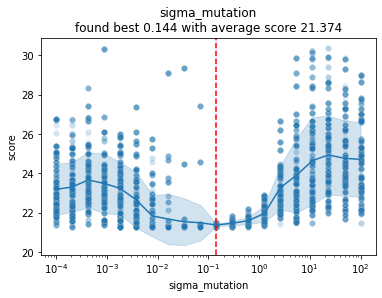

In [99]:
with Pool(THREADS) as pool:
     plot_factor_dependency('sigma_mutation', np.logspace(-4, 2, base=10, num=20), reps=REPS, xlog=True, pool=pool)

**Wnioski**



Dla małych wartości sigma, odchylenie standardowe najlepszego znalezionego wyniku z wielu przebiegów algorytmu jest duże, i 
średnia wyników jest nieoptymalna. Wynika to z tego, że efekt mutacji jest pomijalnie mały, wszystko wtedy zależy od krzyżowania i początkowej inicjalizacji populacji.

Dla sigma równej 0,144 wartości znalezionych rozwiązań są najmniejsze i mają małe odchylenie standardowe.

Dla dużych wartości sigma, wynik funkcji score znowu rośnie, odchylenie drastycznie się zwiększa wraz ze wzrostem wartości sigma. Dla dużej wartości sigma efekt mutacji jest tak znaczący, że nawet optymalne rozwiązanie po zmutowaniu stanie się w przybliżeniu losowym elementem populacji.


## Hiperparametr wielkość populacji

Dla domyślnej wartości sigmy 0.75

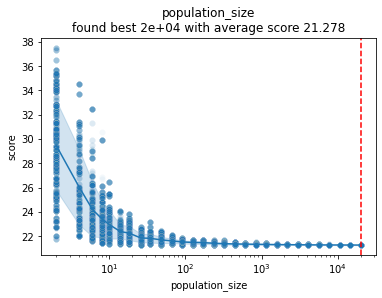

In [100]:
with Pool(THREADS) as pool:
    plot_factor_dependency('population_size', np.logspace(0, 4, base=10, num=30).round().astype(np.int32) * 2, reps=REPS, xlog=True, pool=pool) 

**WNIOSKI**

Dla małej wartości populacji ( od zera do  10 osobników) występuje duże odchylenie standardowe, wraz ze wzrostem wielkości populacji odchylenie zmniejsza się, aż zauważamy, że najbardziej optymalna wartość hiperparametru to graniczna wartość wykresu ( score zbiega do asymptoty ), trzeba liczyć się rownież, że im większy rozmiar populacji tym dłuższy czas programu. 

Początkowe duże odchylenie wynika bezpośrednio z tego, im mniej osobników tym mamy mniej możliwości dokonywania operacji genetycznych, co wiąże się z mniejszym znalezieniem najniższej wartości score, im więcej osobników w populacji tym algorytm jest znacznie dokładniejszy.

## Wykres hiperparametru wielkości populacji dla zmniejszonej wartości sigma 

Sigma zmniejszona do wartości **0.05**

Dla małej wartości sigma, może się zdarzyć ze rozwiązanie ugrzęznie w lokalnym minimum. Nie można zauważyć tego po próbach z obecną funkcją fitnessu z selekcją ruletkową ( przez to ze punkty z mniejszym scorem maja tylko troszke wieksze prawdopodobienstwo wybrania, np punkt (0,0) o scorze 37.59 ma fitness 0.0266, a minimum globalne (1,1) o scorze 21.26 ma fitness 0.047, co oznacza ze minimum globalne bedzie wybrane tylko z prawie dwa razy wiekszym prawdopodobienstwem. ).

Zeby zaobserowac efekt ugrzezania w minimum lokalnym, wyostrzam funkcję fitnessu ( przez podniesienie do potęgi )

In [42]:
score(1.,1.).item(), 1/score(1.,1.).item(), score(0.,0.).item(), 1/score(0.,0.).item()

(21.26435864903798,
 0.047027047300353966,
 37.59298910067517,
 0.026600704650592416)

In [32]:
def fitness(population):
    return (1 / score(population[:, 0], population[:, 1])) ** 50

Funkcja ma dwa minima lokalne (-0.5,1) oraz (1,-1) 9i jedno minimum globalne (1,1).

In [43]:
score(-0.5, 1), score(1., -1)

(array(29.55874655), array(31.58089551))

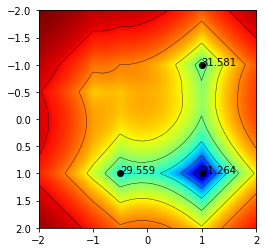

In [44]:
minima = [(-0.5, 1.), (1., -1.), (1., 1.)]
plot_range = 2
N = 200
X, Y = np.meshgrid(np.linspace(-plot_range, plot_range, N), np.linspace(-plot_range, plot_range, N))
Z = score(X, Y)
plt.imshow(Z, extent=[-plot_range, plot_range, plot_range, -plot_range], cmap='jet')
plt.contour(Z, extent=[-plot_range, plot_range, -plot_range, plot_range], colors='black', linewidths=0.4)

for point in minima:
    plt.scatter(point[0], point[1], color='black')
    plt.text(s=f'{score(point[0], point[1]).item():.3f}', x=point[0], y=point[1])

Dla zmniejszonej wartości sigma obserwujemy zjawisko, ugrzeznięcia osobników w lokalnych minimach funkcji, wiąże się to z tym im mniej osobników oraz mała wartość zasięgu mutacji tym te osobniki nie mogą wybić się do globalnego optima i zostają w starym punkcie.

Na rysunku widać powyżej opisane zjawisko. Przerywane linie oznaczają wartości minimów.

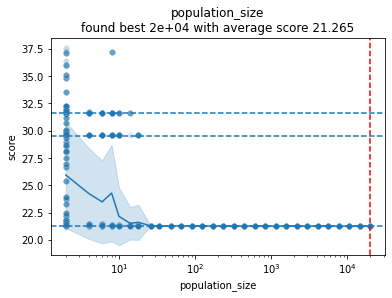

In [47]:
with Pool(THREADS) as pool:
    plot_factor_dependency('population_size', np.logspace(0, 4, base=10, num=30).round().astype(np.int32) * 2, reps=REPS, xlog=True, pool=pool, show=False,
        default_args=DEFAULT_ARGUMENTS | {'sigma_mutation': 0.05}
    )
    for point in minima:
        plt.axhline(score(point[0], point[1]), linestyle='dashed')
    plt.show()

In [48]:
# Powrot do starej funkcji fitness
def fitness(population):
    return 1 / score(population[:, 0], population[:, 1])

## Hiperparametr prawdopodobieństwo krzyżowania

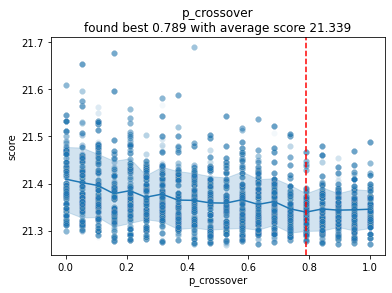

In [49]:
with Pool(THREADS) as pool:
    plot_factor_dependency('p_crossover', np.linspace(0, 1, num=20), reps=REPS, pool=pool,
                           default_args=DEFAULT_ARGUMENTS | {'sigma_mutation': 0.14})

**WNIOSKI**

Obserwujemy małe wartości odchyleń standardowych dla większości wartości parametru krzyżowania. (0,1 wartość odchylenia -> inna skala wykresu)

Dla krzyżowania jednopunktowego przy danym algorytmie powinniśmy wybrać wartość prawdopodobieństwa krzyżowania dosyć sporą równą 0.79. Różnica między najlepsza a najgorsza wartościa tego prawdopodobienstwa daje roznice w scorze około 0.05. Ma to małe znaczenie.


## Hiperparametr prawdopodobieństwo mutacji

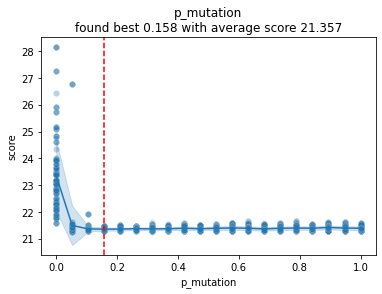

In [52]:
with Pool(THREADS) as pool:
    plot_factor_dependency('p_mutation', np.linspace(0, 1, num=20), reps=REPS, pool=pool,
                           default_args=DEFAULT_ARGUMENTS | {'sigma_mutation': 0.14})

**WNIOSKI**

Najmniejsza wartość średniej wartości score została znaleziona przy domyślnych parametrach dla wartości prawdopodobieństwa mutacji 0,158

Dla małej wartości prawd. mutacji mamy analogiczny efekt do małej wartości sigmy tzn. efekt mutacji jest pomijalnie mały, wszystko wtedy zależy od krzyżowania i początkowej inicjalizacji populacji



## Hiperparametr liczba iteracji

Rozwiązanie dla 1024 repetycji. Dla kazdego przebiegu zapamietujemy historię, a nastepnie ją wizualizujemy.

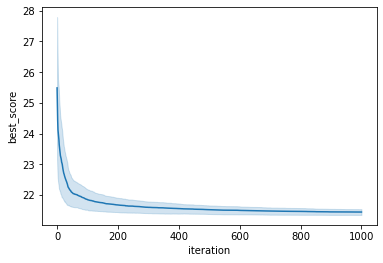

In [14]:
with Pool(THREADS) as pool:
    iteration_plot(reps=REPS, pool=pool,
                   args=DEFAULT_ARGUMENTS | {'iterations': 1000})

**Wnioski**:


Wraz ze zwiększeniem liczby iteracji minimalizuje się najlepsza wartość funkcji score, widać że optymalna wartośc została znalezniona przy około 400 liczbach iteracji, co pokazuje że nie jest konieczne wykonywanie powyższego algorytmu ewolucyjnego dla na przykład 1000 iteracji.

Jednak przy wybraniu mniejszej liczby iteracji (około 100) występuje duże odchylenie standardowe, więc warto wybrać zdecydowanie większe wartości liczby iteracji.

## Lokalizacja fabryki przy najlepszych hiperparametrach

In [15]:
best = evolution(**(DEFAULT_ARGUMENTS | {
    'sigma_mutation': 0.14 ,
    'population_size': 10000,
    'p_crossover': 0.79,
    'p_mutation': 0.16}))
print(f'found best at {best} with score {score(best[0], best[1])}')

found best at [0.99999679 1.00000358] with score 21.264504482453358


Najlepsza lokalizacja fabryki została znaleziona z lepszą precyzją, niż z domyślnymi parametrami. Wtedy wartość (21.76) teraz (21.26) wartość score.

# Animacja

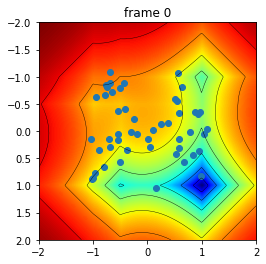

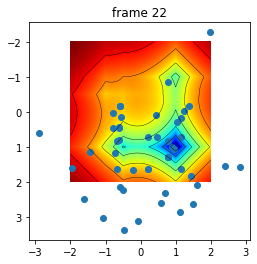

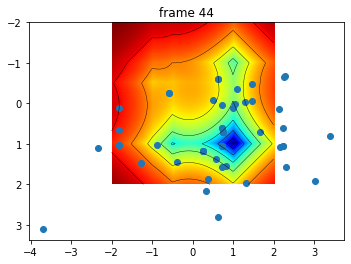

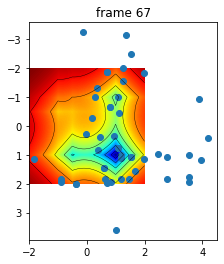

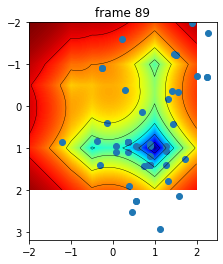

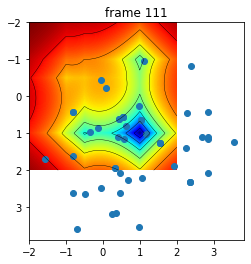

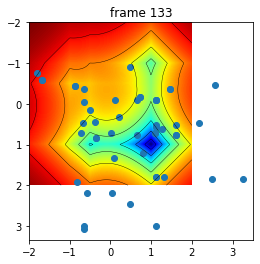

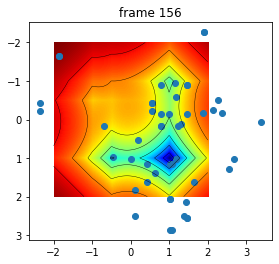

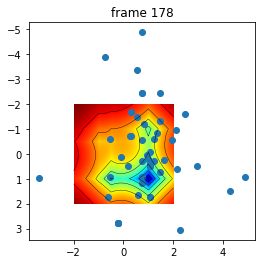

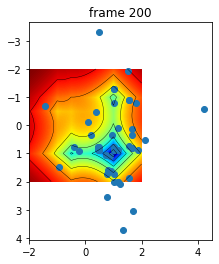

In [97]:
animation(DEFAULT_ARGUMENTS | {'sigma_mutation': 0.8})

**WNIOSKI**

Dla dużej wartości hiperparametru zasięgu mutacji (sigma) osobniki nie mogą sie zbiec do optima globalnego.

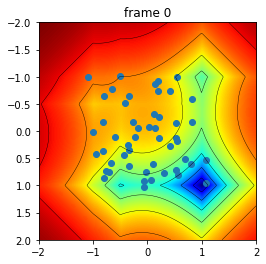

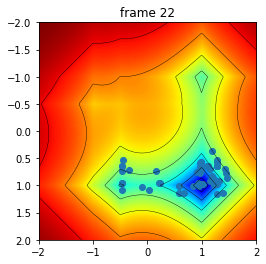

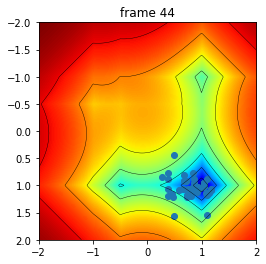

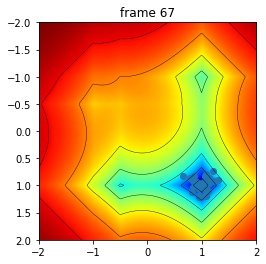

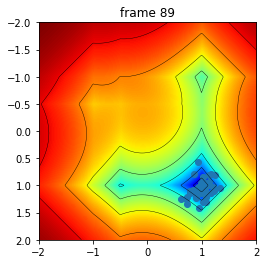

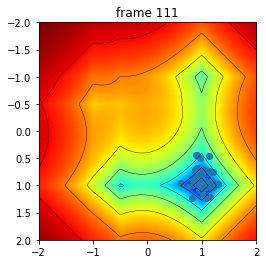

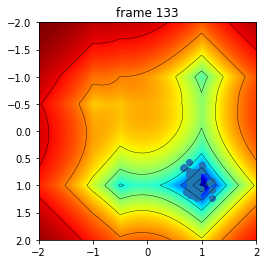

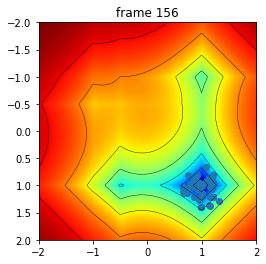

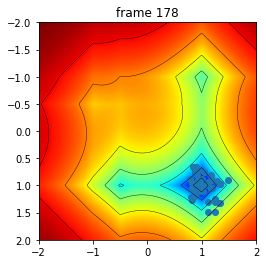

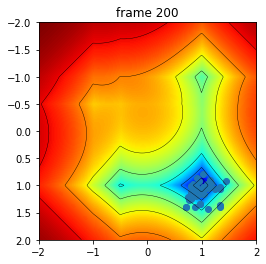

In [90]:
animation(DEFAULT_ARGUMENTS | {'sigma_mutation': 0.1})

**WNIOSKI**

Im mniejsza wartość parametru sigma (najbardziej optymalna dla podanego algorytmu ewolucyjnego) widać zbieganie osobników do globalnego optimum funkcji.